In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings('ignore')


import cv2
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import random
from skimage import img_as_ubyte
from skimage.util import random_noise


import os
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()


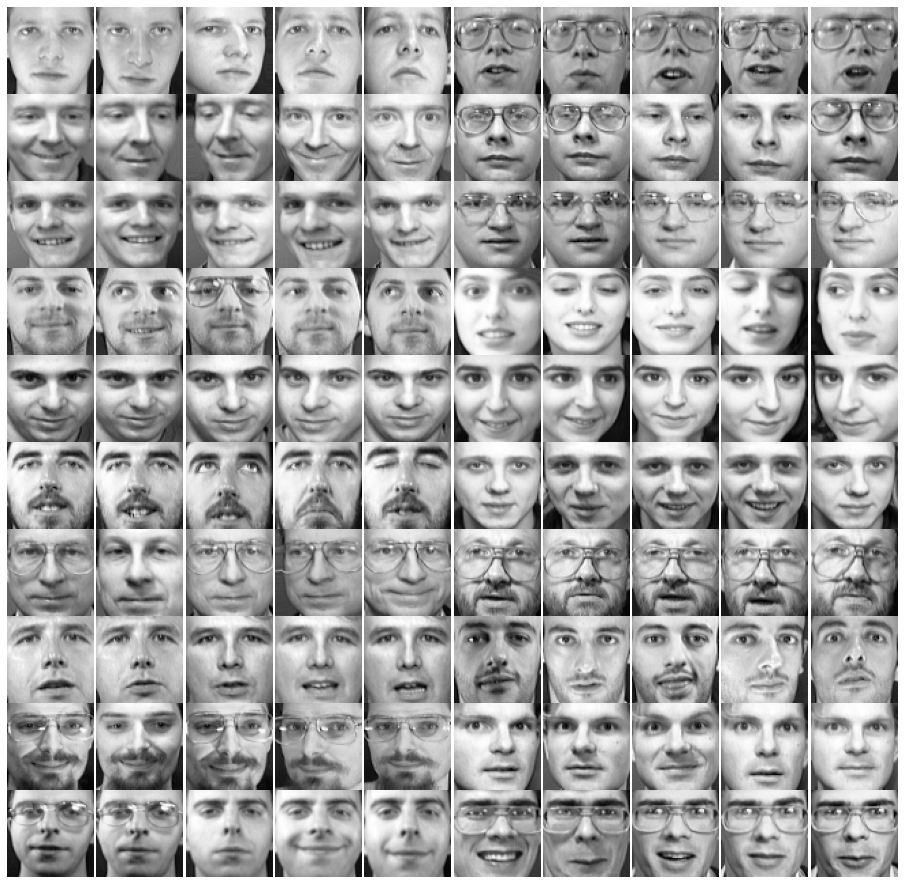

In [2]:
fig, axes = plt.subplots(10, 10, figsize=(16, 16))
fig.subplots_adjust(hspace=0, wspace=0)
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i*2], cmap='gray')
    ax.axis('off')

In [3]:
# inicio el metodo
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
# obtengo los indices para el train_valid y el test. (¿porque usa el next?)
train_valid_idx, test_idx = next(strat_split.split(faces['images'], faces['target']))
# genero el train y test
X_train_valid = faces['images'][train_valid_idx]

y_train_valid = faces['target'][train_valid_idx]
X_test = faces['images'][test_idx]
y_test = faces['target'][test_idx]

# mismo procedimiento pero separo el train de la validacion
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

## Data augmentation

https://www.tensorflow.org/tutorials/images/data_augmentation

In [20]:
#Lets define functions for each operation
def anticlockwise_rotation(image):
    angle= random.randint(0,10)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,10)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image, (3,3),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,5))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

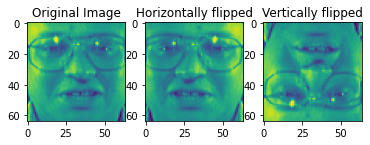

In [21]:
img=X_train[0]
plt.subplot(131) 
plt.title("Original Image") 
plt.imshow(img)

hflipped_image= np.fliplr(img) #fliplr reverse the order of columns of pixels in matrix
plt.subplot(132) 
plt.title("Horizontally flipped")
plt.imshow(hflipped_image)

vflipped_image= np.flipud(img) #flipud reverse the order of rows of pixels in matrix
plt.subplot(133)
plt.title("Vertically flipped")
plt.imshow(vflipped_image)
plt.show()


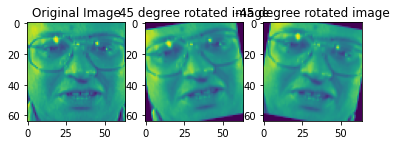

In [23]:
r_image = rotate(img, angle=10) # angle value is positive for anticlockwise rotation 
r_image1 = rotate(img, angle=-10) #angle value is negative for clockwise rotation

plt.subplot(131)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(132)
plt.imshow(r_image)
plt.title("45 degree rotated image")
plt.subplot(133)
plt.imshow(r_image1)
plt.title("-45 degree rotated image")
plt.show()



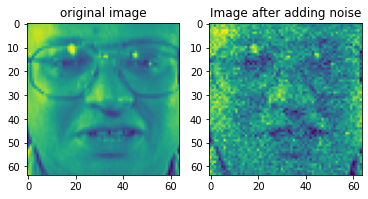

In [9]:
noisy_image= random_noise(img)

plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Image after adding noise')
plt.imshow(noisy_image)



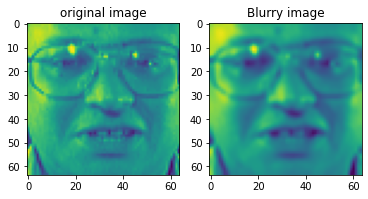

In [10]:
blur_image= cv2.GaussianBlur(img, (3,3),0)

plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Blurry image')
plt.imshow(blur_image_)



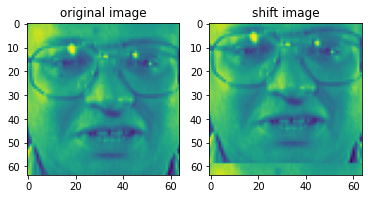

In [26]:
shift_image= warp_shift(X_train[0])

plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(X_train[0])
plt.subplot(1,2,2)
plt.title('shift image')
plt.imshow(shift_image)



In [25]:
transformations = {'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                   'warp shift': warp_shift,
                   'adding noise': add_noise,
                   'blurring image': blur_image
                 }     


images_to_generate=280*100  # cantidad actual de train * 100
i=1                        
X_train_aug=[]

while i<=images_to_generate:    
    original_image = X_train[random.randint(0,len(X_train)-1)]
    transformed_image=None
#     print(i)
    n = 0       #variable to iterate till number of transformation to apply
    transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
    while n <= transformation_count:
        key = random.choice(list(transformations)) #randomly choosing method to call
        trans_f=transformations[key]
        transformed_image = trans_f(original_image)
        n = n + 1
    X_train_aug.append(transformed_image)
    i =i+1


In [27]:
np.shape(X_train_aug)


(28000, 64, 64)

# (CORREGIR)

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [62]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',strides=(1,1), input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu'))


# (CORREGIR)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

# (CORREGIR)

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [63]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(40))

In [64]:
# para ver la arquitectura del modelo
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 flatten_9 (Flatten)         (None, 53824)             0         
                                                                 
 dense_18 (Dense)            (None, 64)                3444800   
                                                                 
 dense_19 (Dense)            (None, 40)                2600      
                                                      

## Copilo y entreno el modelo

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, 
                    validation_data=(X_valid, y_valid))

Epoch 1/25
9/9 [==============================] - 2s 201ms/step - loss: 3.7881 - accuracy: 0.0393 - val_loss: 3.6651 - val_accuracy: 0.1375
Epoch 2/25
9/9 [==============================] - 2s 185ms/step - loss: 3.6412 - accuracy: 0.1179 - val_loss: 3.5772 - val_accuracy: 0.1125
Epoch 3/25
9/9 [==============================] - 3s 317ms/step - loss: 3.4940 - accuracy: 0.1536 - val_loss: 3.3673 - val_accuracy: 0.2875
Epoch 4/25
9/9 [==============================] - 2s 183ms/step - loss: 3.1635 - accuracy: 0.2893 - val_loss: 3.0172 - val_accuracy: 0.2625
Epoch 5/25
9/9 [==============================] - 2s 180ms/step - loss: 2.6315 - accuracy: 0.4036 - val_loss: 2.4475 - val_accuracy: 0.4000
Epoch 6/25
9/9 [==============================] - 2s 181ms/step - loss: 1.9982 - accuracy: 0.5607 - val_loss: 1.8891 - val_accuracy: 0.5375
Epoch 7/25
9/9 [==============================] - 2s 181ms/step - loss: 1.3548 - accuracy: 0.7036 - val_loss: 1.2978 - val_accuracy: 0.7000
Epoch 8/25
9/9 [====

3/3 - 0s - loss: 0.3307 - accuracy: 0.9375 - 120ms/epoch - 40ms/step


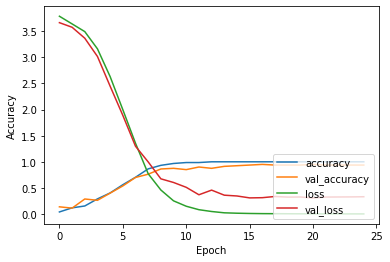

In [70]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=2)

In [67]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

2/2 - 0s - loss: 0.4857 - accuracy: 0.8750 - 68ms/epoch - 34ms/step


In [69]:
history.history

{'loss': [3.78814435005188,
  3.641178846359253,
  3.493971586227417,
  3.1634521484375,
  2.631528377532959,
  1.9981802701950073,
  1.3548227548599243,
  0.7710224986076355,
  0.45954185724258423,
  0.251984179019928,
  0.14861969649791718,
  0.08233550190925598,
  0.04784350097179413,
  0.022785335779190063,
  0.015050575137138367,
  0.010133184492588043,
  0.007199910935014486,
  0.005955483764410019,
  0.004717665258795023,
  0.003855912247672677,
  0.003338513197377324,
  0.0028331640642136335,
  0.0022391604725271463,
  0.0019083167426288128,
  0.0015978923765942454],
 'accuracy': [0.03928571566939354,
  0.11785714328289032,
  0.15357142686843872,
  0.28928571939468384,
  0.4035714268684387,
  0.5607143044471741,
  0.7035714387893677,
  0.8642857074737549,
  0.9321428537368774,
  0.9678571224212646,
  0.9857142567634583,
  0.9857142567634583,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [3.665118455886841,
  3.577216386